#  Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

3.7.0


# Załadowanie danych

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


In [3]:
%ls -l ../data

total 1012
drwxr-xr-x 4 torak28 torak28 290816 Mar 30 13:50 test/
drwxr-xr-x 4 torak28 torak28 737280 Mar 30 13:40 train/


# Stałe

In [4]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [5]:
'''
Opis danych:
1 - psy
2 - koty
'''

dogs_folder = os.listdir('../data/train/dogs')
cats_folder = os.listdir('../data/train/cats')

filenames = []
categories = []
for filename in dogs_folder:
    categories.append(1)
    filenames.append(filename)

for filename in cats_folder:
    categories.append(0)
    filenames.append(filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [6]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,category
0,cat.7740.jpg,0
1,dog.9963.jpg,1
2,dog.4764.jpg,1
3,dog.4344.jpg,1
4,cat.9257.jpg,0


In [8]:
df.shape

(20000, 2)

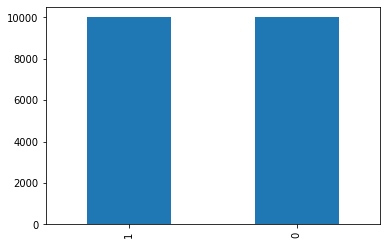

In [9]:
df['category'].value_counts().plot.bar()

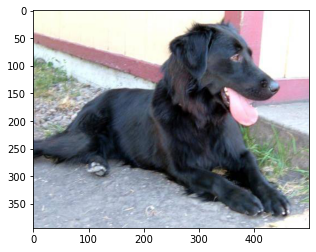

In [11]:
sample = random.choice(filenames)
path = '../data/train/dogs/' if sample.split('.')[0] == 'dog' else '../data/train/cats/'
image = load_img(path + sample)
plt.imshow(image)